In [27]:
import torch
import matplotlib.pyplot as plt
from dataloaders.dataloader import get_molding_loader, get_leadframe_loader
import torchvision
import numpy as np
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')

def unnormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if image_tensor.is_cuda:
        mean = torch.tensor(mean, device=image_tensor.device).view(3, 1, 1)
        std = torch.tensor(std, device=image_tensor.device).view(3, 1, 1)
    else:
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
    
    image_tensor = image_tensor * std + mean
    # 이미지의 픽셀 값 범위를 [0, 1]로 제한합니다.
    # image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor

def get_feautures_from_model(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for imgs, label in loader:
            feature = model(imgs)
            feature = feature.view(feature.size(0), -1)
            features.append(feature)
            labels.append(label)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

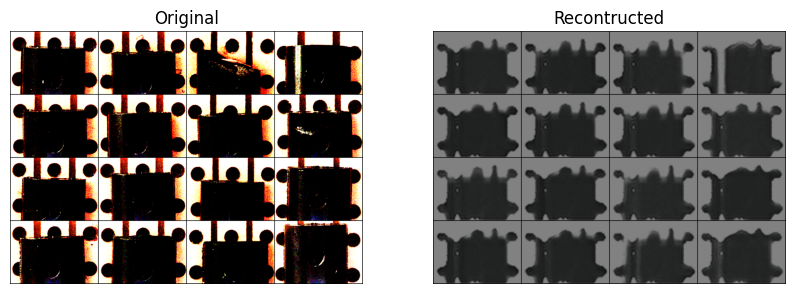

In [29]:
model = torch.jit.load('./model_files/deepSVDD_split/pretrain_molding.pt', map_location=torch.device(device))
model.eval()

loader = get_molding_loader('./datas/test_molding.csv', 16)
imgs, _ = next(iter(loader))
imgs = imgs.to(device)

with torch.no_grad():
    recon = model(imgs)

imgs = unnormalize(imgs)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
imshow(torchvision.utils.make_grid(imgs.cpu().data, nrow=4))
plt.title('Original')

plt.subplot(1,2,2)
imshow(torchvision.utils.make_grid(recon.cpu().data, nrow=4))
plt.title('Recontructed')

plt.show()

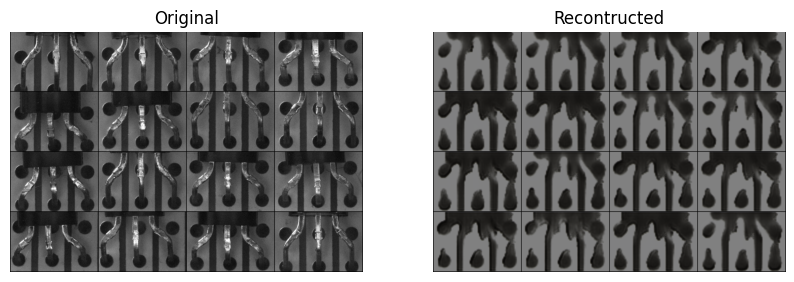

In [23]:
model = torch.jit.load('./model_files/deepSVDD_split/pretrain_leadframe.pt', map_location=torch.device(device))
model.eval()

loader = get_leadframe_loader('./datas/train_leadframe.csv', 16)
imgs, _ = next(iter(loader))
imgs = imgs.to(device)

with torch.no_grad():
    recon = model(imgs)

imgs = imgs.mul_(0.225).add_(0.406)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
imshow(torchvision.utils.make_grid(imgs.cpu().data, nrow=4))
plt.title('Original')

plt.subplot(1,2,2)
imshow(torchvision.utils.make_grid(recon.cpu().data, nrow=4))
plt.title('Recontructed')

plt.show()

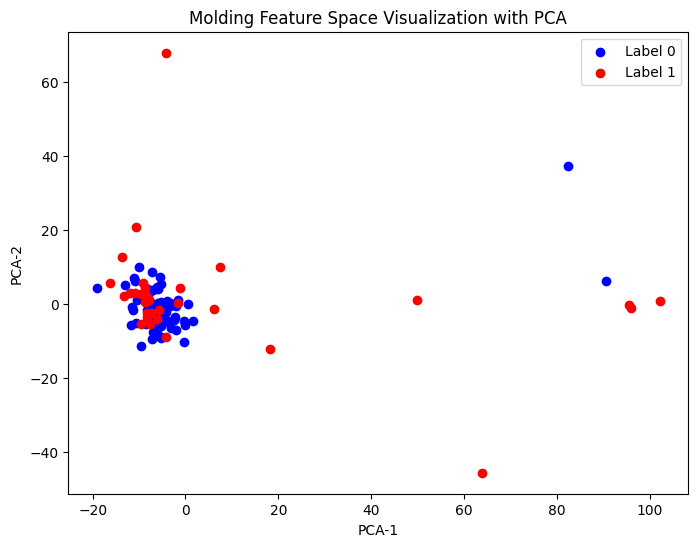

In [17]:
model = torch.jit.load('./model_files/deepSVDD_split/train_molding.pt', map_location=torch.device(device))
model.eval()

loader = get_molding_loader('./datas/test_molding.csv', 16)
features, labels = get_feautures_from_model(model, loader)
features_numpy = features.detach().numpy()
labels_numpy = labels.detach().numpy().flatten()

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_numpy)

plt.figure(figsize=(8, 6))

plt.scatter(features_2d[labels_numpy == 0, 0], features_2d[labels_numpy == 0, 1], c='blue', label='Label 0')
plt.scatter(features_2d[labels_numpy == 1, 0], features_2d[labels_numpy == 1, 1], c='red', label='Label 1')

plt.title('Molding Feature Space Visualization with PCA')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.show()

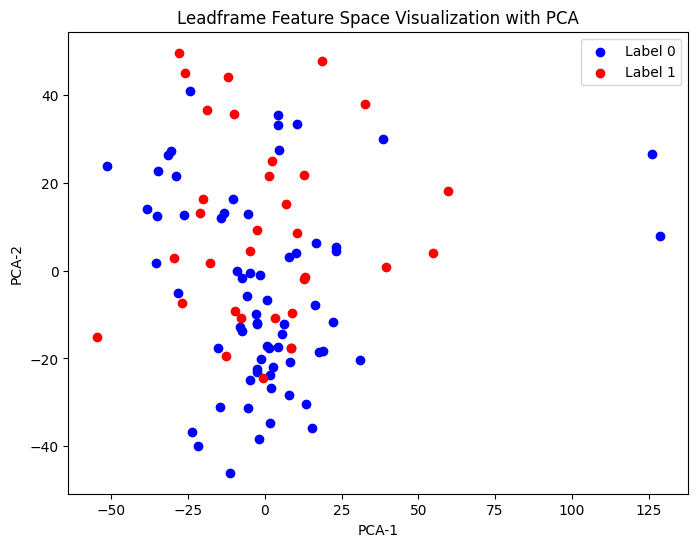

In [19]:
model = torch.jit.load('./model_files/deepSVDD_split/train_leadframe.pt', map_location=torch.device(device))
model.eval()

loader = get_leadframe_loader('./datas/test_leadframe.csv', 16)
features, labels = get_feautures_from_model(model, loader)
features_numpy = features.detach().numpy()
labels_numpy = labels.detach().numpy().flatten()

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_numpy)

plt.figure(figsize=(8, 6))

plt.scatter(features_2d[labels_numpy == 0, 0], features_2d[labels_numpy == 0, 1], c='blue', label='Label 0')
plt.scatter(features_2d[labels_numpy == 1, 0], features_2d[labels_numpy == 1, 1], c='red', label='Label 1')

plt.title('Leadframe Feature Space Visualization with PCA')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.show()